In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station, var):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    if var == 'RAOBCORE_bias_estimate':
        file = ('./Temperature_adjustment/0'+station+'/feedbackglobbincorrsave0'+station+'.nc')
    elif var == 'RISE_bias_estimate':
        file = glob.glob('./Temperature_adjustment/0'+station+'/*corrsave*rio24*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    breakdates = []
    for i in data.datum[:][0]:
        breakdates.append(date0 + datetime.timedelta(days=int(i)))
    
    press = data.press[:]
    nightadj = data.rasocorr[0,:]
    dayadj = data.rasocorr[1,:]
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
#     breakdates.append(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    dates = breakdates
#     dates.reverse()
    print(dates)
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd[var].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd[var].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, calc_day_out, calc_night_out, cds_day_out, cds_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(dates[1:], cdata[str(plev)], label='CDS')
    ax.scatter(dates[1:], adata[str(plev)], label='Calc')

    ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

2021-04-28 14:12:12,965 INFO Welcome to the CDS
2021-04-28 14:12:12,966 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:12:13,248 INFO Request is completed
2021-04-28 14:12:13,249 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-28 14:12:14,606 INFO Download rate 20.8M/s  
2021-04-28 14:12:14,708 INFO Reading Profile on slice(None, None, None)
2021-04-28 14:12:19,136 INFO Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-28 14:12:19,138 INFO NumExpr defaulting to 8 threads.


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 12, 0, 0), datetime.datetime(1952, 6, 17, 0, 0), datetime.datetime(1955, 7, 20, 0, 0), datetime.datetime(1956, 8, 4, 0, 0), datetime.datetime(1958, 8, 12, 0, 0), datetime.datetime(1960, 11, 11, 0, 0), datetime.datetime(1963, 9, 6, 0, 0), datetime.datetime(1964, 12, 20, 0, 0), datetime.datetime(1970, 9, 6, 0, 0), datetime.datetime(1975, 8, 6, 0, 0), datetime.datetime(1977, 12, 3, 0, 0), datetime.datetime(1980, 9, 13, 0, 0), datetime.datetime(1982, 11, 20, 0, 0), datetime.datetime(1984, 1, 26, 0, 0), datetime.datetime(1989, 6, 30, 0, 0), datetime.datetime(1992, 2, 27, 0, 0), datetime.datetime(1995, 6, 11, 0, 0), datetime.datetime(1997, 7, 11, 0, 0), datetime.datetime(1999, 9, 4, 0, 0), datetime.datetime(2009, 3, 20, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


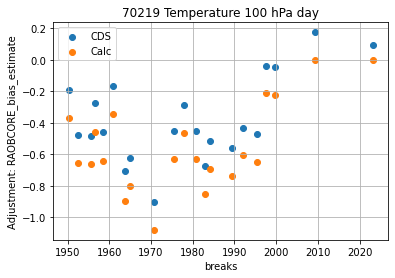

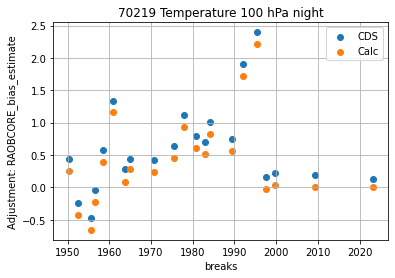

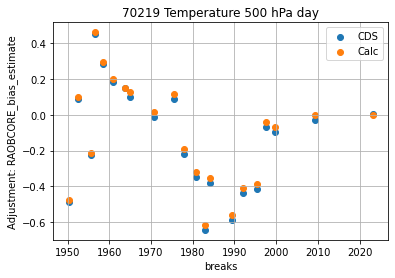

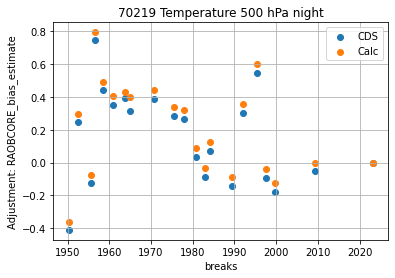

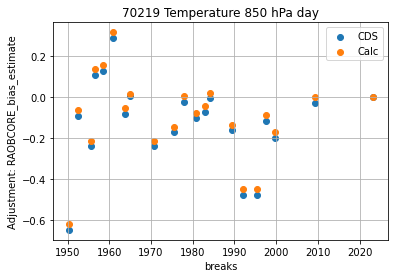

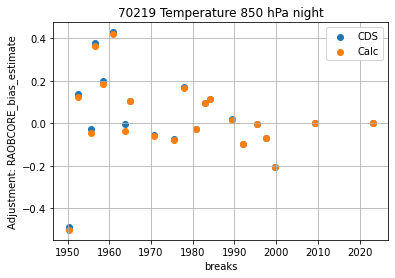

In [4]:
station = '70219'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:12:33,255 INFO Welcome to the CDS
2021-04-28 14:12:33,257 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:12:33,342 INFO Request is completed
2021-04-28 14:12:33,344 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-28 14:12:34,636 INFO Download rate 21.8M/s  
2021-04-28 14:12:34,736 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 13, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1955, 7, 21, 0, 0), datetime.datetime(1956, 8, 5, 0, 0), datetime.datetime(1958, 8, 13, 0, 0), datetime.datetime(1960, 11, 12, 0, 0), datetime.datetime(1963, 9, 7, 0, 0), datetime.datetime(1964, 12, 21, 0, 0), datetime.datetime(1970, 9, 7, 0, 0), datetime.datetime(1975, 8, 7, 0, 0), datetime.datetime(1977, 12, 4, 0, 0), datetime.datetime(1980, 9, 14, 0, 0), datetime.datetime(1982, 11, 21, 0, 0), datetime.datetime(1984, 1, 27, 0, 0), datetime.datetime(1989, 7, 1, 0, 0), datetime.datetime(1992, 2, 28, 0, 0), datetime.datetime(1995, 6, 12, 0, 0), datetime.datetime(1997, 7, 12, 0, 0), datetime.datetime(1999, 9, 5, 0, 0), datetime.datetime(2009, 3, 21, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


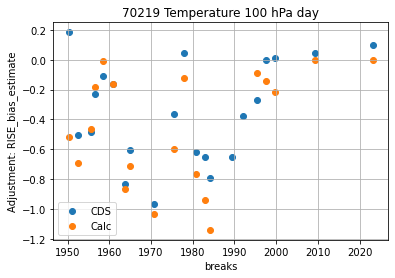

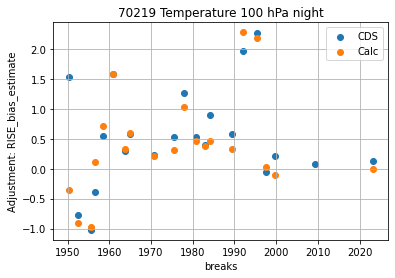

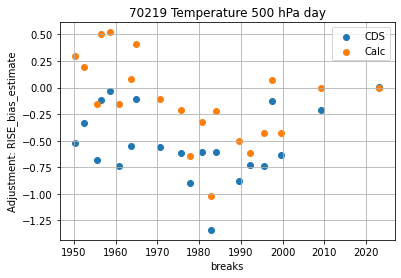

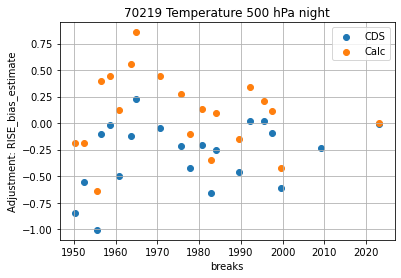

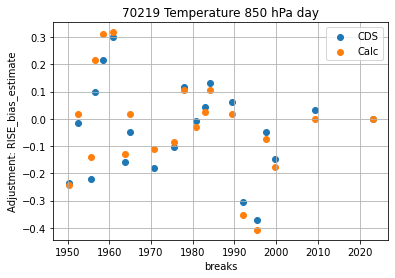

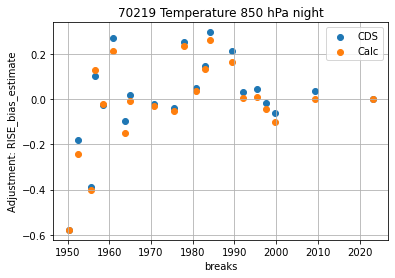

In [5]:
station = '70219'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:12:53,490 INFO Welcome to the CDS
2021-04-28 14:12:53,491 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:12:53,566 INFO Request is completed
2021-04-28 14:12:53,567 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-28 14:12:55,402 INFO Download rate 16.7M/s  
2021-04-28 14:12:55,543 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1956, 4, 28, 0, 0), datetime.datetime(1958, 5, 19, 0, 0), datetime.datetime(1959, 4, 1, 0, 0), datetime.datetime(1960, 5, 27, 0, 0), datetime.datetime(1965, 7, 12, 0, 0), datetime.datetime(1967, 11, 27, 0, 0), datetime.datetime(1972, 3, 13, 0, 0), datetime.datetime(1975, 1, 4, 0, 0), datetime.datetime(1978, 12, 31, 0, 0), datetime.datetime(1981, 1, 25, 0, 0), datetime.datetime(1981, 10, 14, 0, 0), datetime.datetime(1984, 5, 31, 0, 0), datetime.datetime(1988, 1, 26, 0, 0), datetime.datetime(1990, 6, 14, 0, 0), datetime.datetime(1995, 11, 22, 0, 0), datetime.datetime(2003, 4, 26, 0, 0), datetime.datetime(2011, 6, 1, 0, 0), datetime.datetime(2014, 11, 12, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


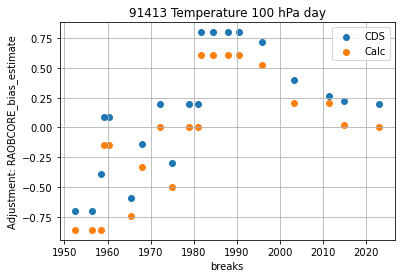

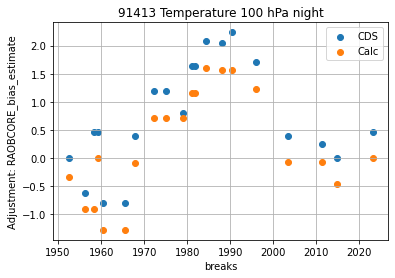

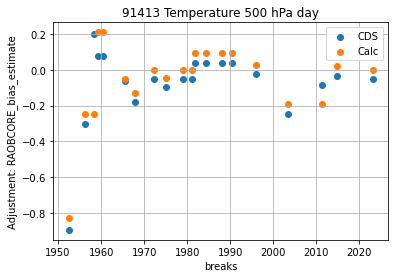

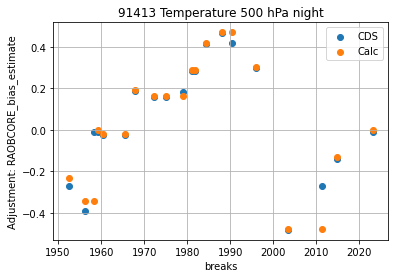

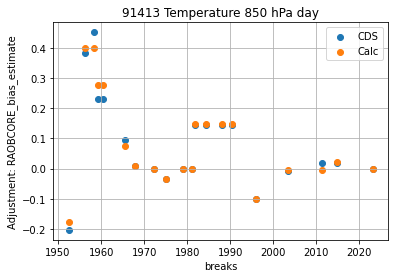

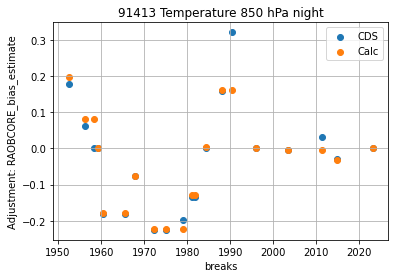

In [6]:
station = '91413'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:13:11,231 INFO Welcome to the CDS
2021-04-28 14:13:11,232 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:13:11,354 INFO Request is completed
2021-04-28 14:13:11,355 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-28 14:13:13,573 INFO Download rate 13.8M/s  
2021-04-28 14:13:13,684 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 19, 0, 0), datetime.datetime(1956, 4, 29, 0, 0), datetime.datetime(1958, 5, 20, 0, 0), datetime.datetime(1959, 4, 2, 0, 0), datetime.datetime(1960, 5, 28, 0, 0), datetime.datetime(1972, 3, 14, 0, 0), datetime.datetime(1975, 1, 5, 0, 0), datetime.datetime(1979, 1, 1, 0, 0), datetime.datetime(1981, 1, 26, 0, 0), datetime.datetime(1981, 10, 15, 0, 0), datetime.datetime(1984, 6, 1, 0, 0), datetime.datetime(1988, 1, 27, 0, 0), datetime.datetime(1990, 6, 15, 0, 0), datetime.datetime(1995, 11, 23, 0, 0), datetime.datetime(2003, 4, 27, 0, 0), datetime.datetime(2011, 6, 2, 0, 0), datetime.datetime(2014, 11, 13, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


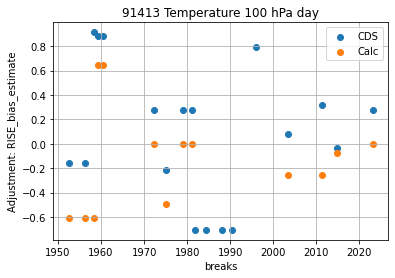

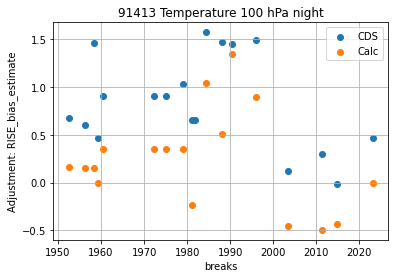

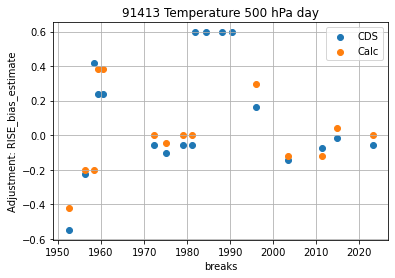

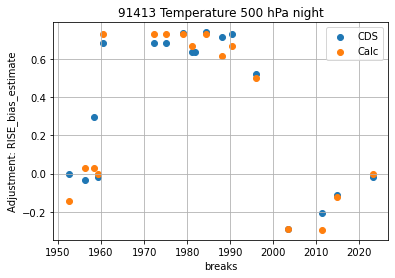

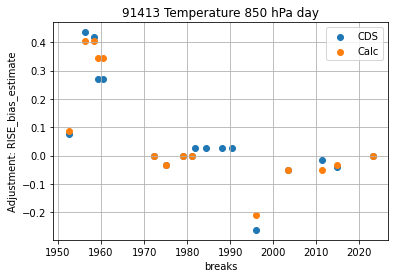

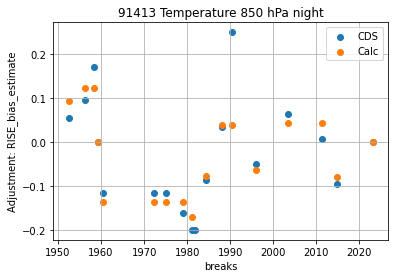

In [7]:
station = '91413'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:13:28,543 INFO Welcome to the CDS
2021-04-28 14:13:28,543 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:13:28,618 INFO Request is completed
2021-04-28 14:13:28,619 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-28 14:13:31,847 INFO Download rate 13.4M/s  
2021-04-28 14:13:31,993 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 2, 0, 0), datetime.datetime(1957, 1, 21, 0, 0), datetime.datetime(1960, 1, 16, 0, 0), datetime.datetime(1962, 2, 8, 0, 0), datetime.datetime(1963, 2, 11, 0, 0), datetime.datetime(1968, 1, 3, 0, 0), datetime.datetime(1970, 3, 3, 0, 0), datetime.datetime(1973, 4, 30, 0, 0), datetime.datetime(1979, 11, 2, 0, 0), datetime.datetime(1984, 8, 6, 0, 0), datetime.datetime(1987, 1, 17, 0, 0), datetime.datetime(1989, 4, 2, 0, 0), datetime.datetime(1991, 2, 16, 0, 0), datetime.datetime(1992, 3, 24, 0, 0), datetime.datetime(1994, 10, 12, 0, 0), datetime.datetime(2004, 5, 12, 0, 0), datetime.datetime(2006, 7, 1, 0, 0), datetime.datetime(2010, 7, 10, 0, 0), datetime.datetime(2017, 2, 3, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


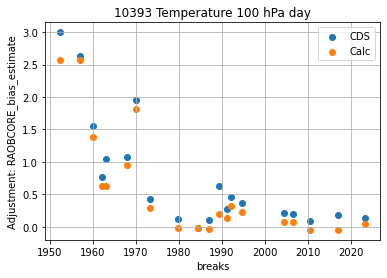

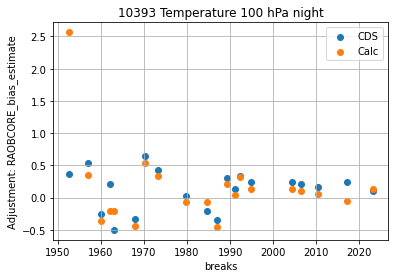

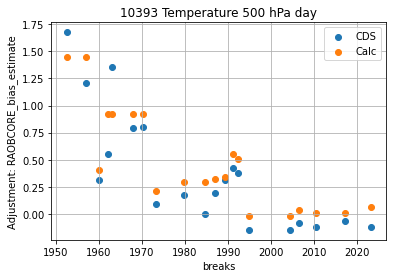

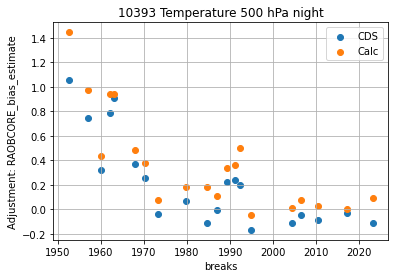

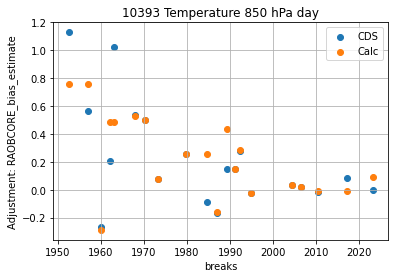

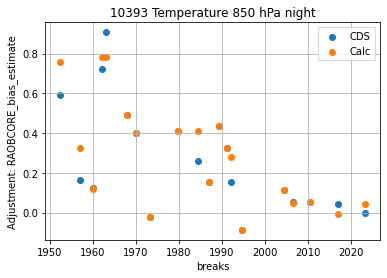

In [8]:
station = '10393'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:14:00,895 INFO Welcome to the CDS
2021-04-28 14:14:00,896 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:14:00,969 INFO Request is completed
2021-04-28 14:14:00,969 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-28 14:14:04,706 INFO Download rate 11.6M/s  
2021-04-28 14:14:04,853 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 3, 0, 0), datetime.datetime(1957, 1, 22, 0, 0), datetime.datetime(1960, 1, 17, 0, 0), datetime.datetime(1962, 2, 9, 0, 0), datetime.datetime(1963, 2, 12, 0, 0), datetime.datetime(1968, 1, 4, 0, 0), datetime.datetime(1970, 3, 4, 0, 0), datetime.datetime(1973, 5, 1, 0, 0), datetime.datetime(1979, 11, 3, 0, 0), datetime.datetime(1984, 8, 7, 0, 0), datetime.datetime(1987, 1, 18, 0, 0), datetime.datetime(1989, 4, 3, 0, 0), datetime.datetime(1991, 2, 17, 0, 0), datetime.datetime(1992, 3, 25, 0, 0), datetime.datetime(1994, 10, 13, 0, 0), datetime.datetime(2004, 5, 13, 0, 0), datetime.datetime(2006, 7, 2, 0, 0), datetime.datetime(2010, 7, 11, 0, 0), datetime.datetime(2017, 2, 4, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


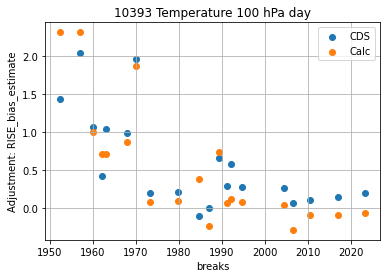

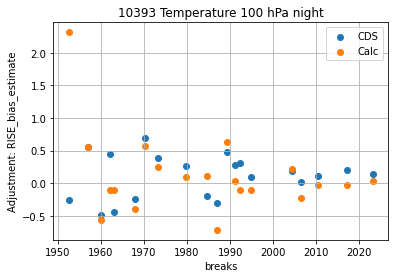

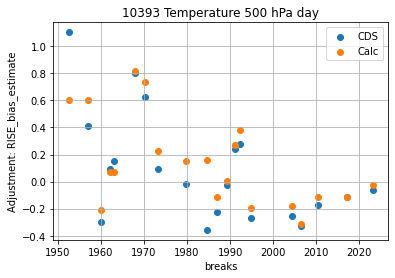

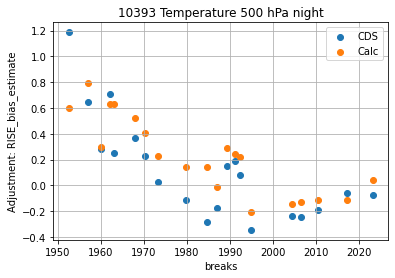

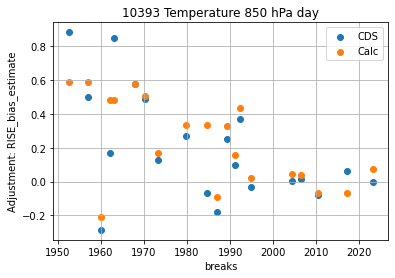

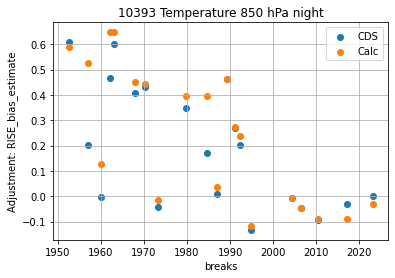

In [9]:
station = '10393'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:14:34,822 INFO Welcome to the CDS
2021-04-28 14:14:34,823 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:14:35,081 INFO Request is completed
2021-04-28 14:14:35,082 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-28 14:14:39,942 INFO Download rate 6M/s     
2021-04-28 14:14:40,044 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 25, 0, 0), datetime.datetime(1951, 9, 12, 0, 0), datetime.datetime(1954, 2, 28, 0, 0), datetime.datetime(1956, 7, 4, 0, 0), datetime.datetime(1958, 6, 23, 0, 0), datetime.datetime(1963, 11, 8, 0, 0), datetime.datetime(1965, 8, 14, 0, 0), datetime.datetime(1966, 10, 23, 0, 0), datetime.datetime(1968, 1, 1, 0, 0), datetime.datetime(1969, 9, 29, 0, 0), datetime.datetime(1973, 2, 13, 0, 0), datetime.datetime(1974, 11, 21, 0, 0), datetime.datetime(1976, 2, 3, 0, 0), datetime.datetime(1980, 3, 30, 0, 0), datetime.datetime(1982, 1, 8, 0, 0), datetime.datetime(1984, 1, 9, 0, 0), datetime.datetime(1987, 4, 16, 0, 0), datetime.datetime(1989, 8, 23, 0, 0), datetime.datetime(1994, 6, 4, 0, 0), datetime.datetime(1996, 8, 11, 0, 0), datetime.datetime(2016, 12, 14, 0, 0), datetime.datetime(2018, 12, 15, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


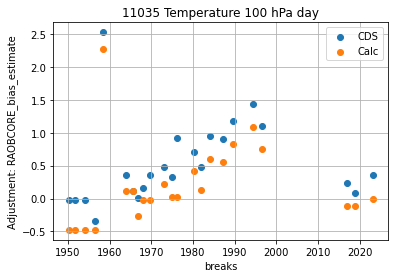

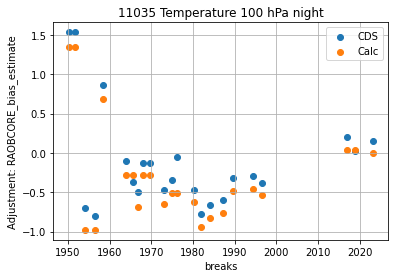

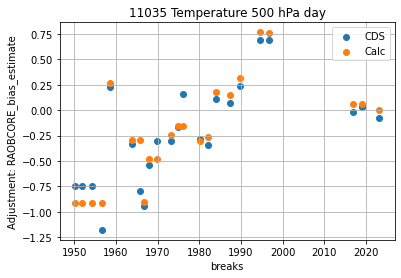

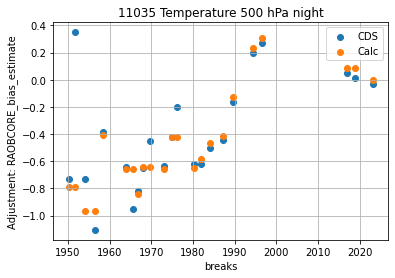

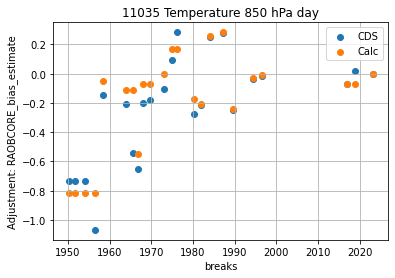

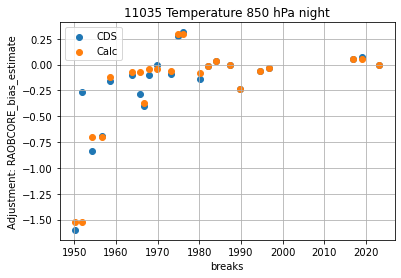

In [10]:
station = '11035'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-04-28 14:14:59,976 INFO Welcome to the CDS
2021-04-28 14:14:59,977 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-28 14:15:00,049 INFO Request is completed
2021-04-28 14:15:00,050 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-28 14:15:03,589 INFO Download rate 8.2M/s   
2021-04-28 14:15:03,692 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 26, 0, 0), datetime.datetime(1951, 9, 13, 0, 0), datetime.datetime(1954, 3, 1, 0, 0), datetime.datetime(1956, 7, 5, 0, 0), datetime.datetime(1958, 6, 24, 0, 0), datetime.datetime(1963, 11, 9, 0, 0), datetime.datetime(1965, 8, 15, 0, 0), datetime.datetime(1966, 10, 24, 0, 0), datetime.datetime(1968, 1, 2, 0, 0), datetime.datetime(1969, 9, 30, 0, 0), datetime.datetime(1973, 2, 14, 0, 0), datetime.datetime(1974, 11, 22, 0, 0), datetime.datetime(1976, 2, 4, 0, 0), datetime.datetime(1980, 3, 31, 0, 0), datetime.datetime(1982, 1, 9, 0, 0), datetime.datetime(1984, 1, 10, 0, 0), datetime.datetime(1987, 4, 17, 0, 0), datetime.datetime(1989, 8, 24, 0, 0), datetime.datetime(1994, 6, 5, 0, 0), datetime.datetime(1996, 8, 12, 0, 0), datetime.datetime(2016, 12, 15, 0, 0), datetime.datetime(2018, 12, 16, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


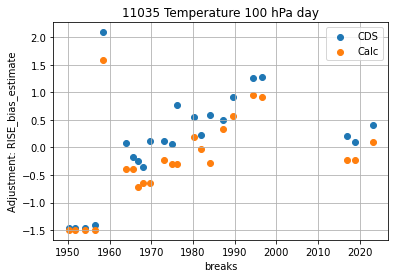

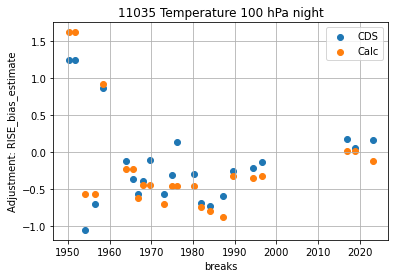

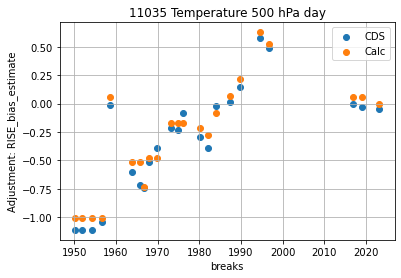

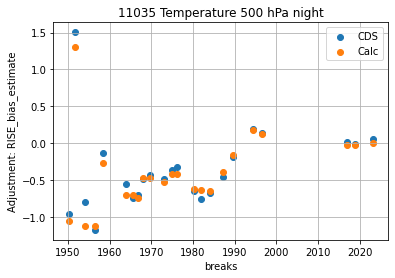

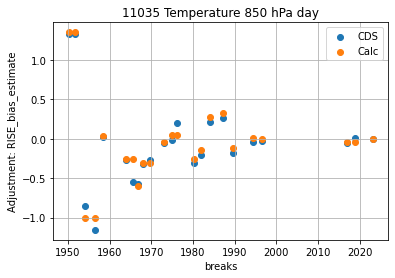

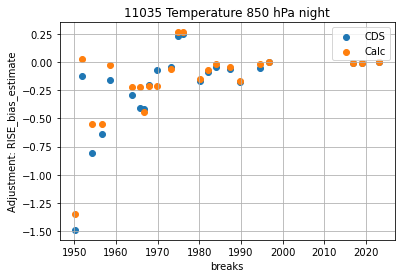

In [11]:
station = '11035'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)